In [1]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install mplfinance
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 52.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

In [2]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")
def get_crypto_syms():
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   return symbols
def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")
def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now
def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):
    address = f"/content/data/{file}"
    data = pd.read_csv(address)
    if len(data.columns) == 7:
      data = data.iloc[:, 1:]
    data = np.array(data)
    data = data.astype(float)
    max_index = data.shape[0]-which_future_or_past
    for i in range(each_row_past,max_index):
        rows = data[i-each_row_past:i, :]
        past_candles = []
        for z in range(1, how_many_past_candles+1):
          past_candles.append((data[i-z][3]+data[i-z][0])/2)
        past_candles = sum(past_candles)/len(past_candles)
        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append((data[i+z][3]+data[i+z][0])/2)
        next_candles = sum(next_candles)/len(next_candles)
        if next_candles > past_candles:
          sugg = 1
        else:
          sugg = 0

        df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])

        df.index.name = "Date"

        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
        
        fig.savefig(address)
        fig.clf()

        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20:
          plt.close("all")
        if i % 270 ==0:
          print("")
    plt.close("all")
    print("")

def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [3]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
#symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols,"5d","1h")

Symbols : 1500
 -- 100 -- 200 -- 300 -- 400 -- 500 -- 600 -- 700 -- 800 -- 900 -- 1000 -- 1100 -- 1200 -- 1300 -- 1400 -- 1500 


Files In Data : 1475
Processing File:
File Number 1: 80/107 90/107 100/107 
File Number 2: 80/107 90/107 100/107 
File Number 3: 80/107 90/107 100/107 
File Number 4: 80/107 90/107 100/107 
File Number 5: 80/107 90/107 100/107 
File Number 6: 80/107 90/107 100/107 
File Number 7: 80/107 90/107 100/107 
File Number 8: 80/107 90/107 100/107 
File Number 9: 80/107 90/107 100/107 
File Number 10: 80/107 90/107 100/107 
File Number 11: 80/107 90/107 100/107 
File Number 12: 80/107 90/107 100/107 
File Number 13: 80/107 90/107 100/107 
File Number 14: 80/107 90/107 100/107 
File Number 15: 80/107 90/107 100/107 
File Number 16: 80/107 90/107 100/107 
File Number 17: 80/107 90/107 100/107 
File Number 18: 80/107 90/107 100/107 
File Number 19: 80/107 90/107 100/107 
File Number 20: 80/107 90/107 100/107 
File Number 21: 80/107 90/107 100/107 
File Number 22: 80/107 90/107 100/107 
File Number 23: 80/107 90/107 100/107 
File Number 24: 80/107 90/107 100/107 
File Number 25: 80/107 90/107 100/1

KeyboardInterrupt: ignored

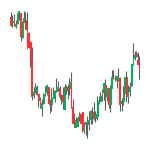

In [4]:
how_many_future_candles = 5
how_many_past_candles = 1
each_row_past = 80


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

In [4]:
folder_name = "143819"

#shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (100, 100)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

(24800, 100, 100)
xTrain : 19840 \ xTest : 4960
yn: 15421 nn: 9379


In [8]:
model = Sequential()

model.add(Conv2D(128,     (2, 2),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32,      (2, 2),activation="relu",)) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,      (2, 2),activation="relu",)) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,      (2, 2),activation="relu",)) 
model.add(Flatten())
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 99, 99, 128)       640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 average_pooling2d_1 (Averag  (None, 16, 16, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 32)        4128      
                                                                 
 average_pooling2d_2 (Averag  (None, 7, 7, 32)        

In [9]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=16,epochs=18,validation_data=(xTest,yTest),shuffle=True)

Epoch 1/18
1240/1240 [==============================] - 17s 13ms/step - loss: 0.6055 - accuracy: 0.6658 - val_loss: 0.5749 - val_accuracy: 0.6960
Epoch 2/18
1240/1240 [==============================] - 15s 12ms/step - loss: 0.5300 - accuracy: 0.7298 - val_loss: 0.5083 - val_accuracy: 0.7452
Epoch 3/18
1240/1240 [==============================] - 16s 13ms/step - loss: 0.4448 - accuracy: 0.7926 - val_loss: 0.4257 - val_accuracy: 0.8089
Epoch 4/18
1240/1240 [==============================] - 16s 13ms/step - loss: 0.3615 - accuracy: 0.8398 - val_loss: 0.3773 - val_accuracy: 0.8361
Epoch 5/18
1240/1240 [==============================] - 16s 13ms/step - loss: 0.2964 - accuracy: 0.8718 - val_loss: 0.4048 - val_accuracy: 0.8415
Epoch 6/18
1240/1240 [==============================] - 15s 12ms/step - loss: 0.2505 - accuracy: 0.8949 - val_loss: 0.3449 - val_accuracy: 0.8655
Epoch 7/18
1240/1240 [==============================] - 16s 13ms/step - loss: 0.2105 - accuracy: 0.9120 - val_loss: 0.3541 -

In [ ]:
model.save(f"1.h5")

In [ ]:
symbol,period,interval="btc-usd","10d","1h"
data = yf.download(tickers=symbol,period=period,interval=interval)
print(data)
data = np.array(data)
data = data.astype(float)
i = -2
rows = data[i-each_row_past:i, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture.png")

In [ ]:
image = cv2.imread("/content/picture.png",0)
dim = (100, 100)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,100,100,1)]])

In [ ]:
tv = TvDatafeed()
data = tv.get_hist(symbol="btcusdt",exchange="binance",interval=Interval.in_1_hour,n_bars=1000)
data = np.array(data)
i = -1
rows = data[i-each_row_past:i, 1:5]
rows.shape
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture1.png")

In [ ]:
image = cv2.imread("/content/picture1.png",0)
dim = (100, 100)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,100,100,1)]])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lst = []
while True:
  ans = input()
  if ans == "exit":
    break
  lst.append(int(ans))
print(sum(max),len(lst))